In [5]:
import pandas as pd
import datetime
import math
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *
import Orange
import numpy as np
from Orange.data import Domain, Table

%matplotlib inline

# Exploratory data Analysis

In [7]:
grocery_items = set()
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        grocery_items.update(line)
output_list = list()
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        row_val = {item:0 for item in grocery_items}
        row_val.update({item:1 for item in line})
        output_list.append(row_val)
grocery_df = pd.DataFrame(output_list)
grocery_df.shape

(9835, 169)

In [10]:
total_item_count = sum(grocery_df.sum())
print("Total item count: ", total_item_count)
item_summary_df = grocery_df.sum().sort_values(ascending=False).reset_index().head(20)
item_summary_df.rename(columns={item_summary_df.columns[0]:"item_name", item_summary_df.columns[1]:"item_count"}, inplace=True)
item_summary_df.head()

Total item count:  43367


,item_name,item_count
0,whole milk,2513
1,other vegetables,1903
2,rolls/buns,1809
3,soda,1715
4,yogurt,1372


Text(0.5,1,'Item sales distribution')

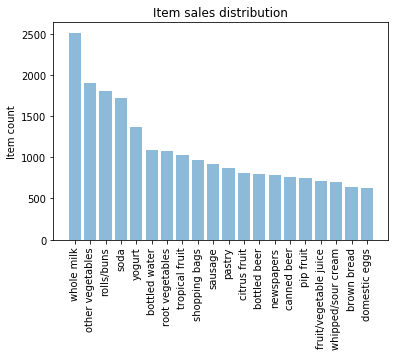

In [13]:
objects = (list(item_summary_df['item_name'].head(20)))
y_pos = np.arange(len(objects))
performance = list(item_summary_df['item_count'].head(20))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel("Item count")
plt.title("Item sales distribution")

In [17]:
item_summary_df["item_perc"] = item_summary_df["item_count"]/total_item_count
item_summary_df["total_perc"] = item_summary_df.item_perc.cumsum()
item_summary_df.head(20)

,item_name,item_count,item_perc,total_perc
0,whole milk,2513,0.057947,0.057947
1,other vegetables,1903,0.043881,0.101829
2,rolls/buns,1809,0.041714,0.143542
3,soda,1715,0.039546,0.183089
4,yogurt,1372,0.031637,0.214725
5,bottled water,1087,0.025065,0.239791
6,root vegetables,1072,0.024719,0.264510
7,tropical fruit,1032,0.023797,0.288307
8,shopping bags,969,0.022344,0.310651
9,sausage,924,0.021307,0.331957


In [16]:
item_summary_df[item_summary_df.total_perc <= 0.5].shape

(19, 4)

# Mining Rules

## Orange Table Data Structure

In [19]:
input_assoc_rules = grocery_df
domain_grocery = Domain([DiscreteVariable.make(name=item, values=['0', '1']) for item in input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain_grocery, X=input_assoc_rules.as_matrix(), Y=None)

## FP Growth Algorithm

In [21]:
#input_df = grocery_df
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, start_item = None, end_item = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',item_count.columns[1]:'item_count'}, inplace=True)
    if not start_item and not end_item: 
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]

In [24]:
output_df, item_counts = prune_dataset(input_df=grocery_df, length_trans=2, total_sales_perc=0.4)
print(output_df.shape)
print(list(output_df.columns))


(4585, 13)
['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags', 'sausage', 'pastry', 'citrus fruit', 'bottled beer']


In [26]:
input_assoc_rules = output_df
domain_grocery = Domain([DiscreteVariable.make(name=item, values=['0', '1']) for item in input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain=domain_grocery, X=input_assoc_rules.as_matrix(), Y=None)
data_gro_1_en, mapping = OneHot.encode(data_gro_1, include_class=False)

In [27]:
min_support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*min_support))
num_trans = input_assoc_rules.shape[0] * min_support
itemsets = dict(frequent_itemsets(data_gro_1_en, min_support=min_support))

num of required transactions =  45


In [28]:
len(itemsets)

166886

In [30]:
confidence = 0.3
rules_df = pd.DataFrame()
if len(itemsets) < 1000000:
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]
    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_gro_1, mapping)}
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    N = input_assoc_rules.shape[0] * 0.5
    rule_stats = list(rules_stats(rules, itemsets, N))
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]        
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 16628 rules generated


In [31]:
(pruned_rules_df[['antecedent','consequent',
                  'support','confidence','lift']].groupby('consequent')
                                                 .max()
                                                 .reset_index()
                                                 .sort_values(['lift','support','confidence'],
                                                ascending=False))

,consequent,antecedent,support,confidence,lift
4,root vegetables,"yogurt, tropical fruit",228,0.463636,1.115306
5,sausage,"shopping bags, rolls/buns",59,0.393162,1.100519
8,tropical fruit,"yogurt, root vegetables",92,0.429907,1.078294
1,citrus fruit,"whole milk, other vegetables, tropical fruit",66,0.333333,1.062819
10,yogurt,"whole milk, tropical fruit",199,0.484211,0.945530
2,other vegetables,"yogurt, whole milk, tropical fruit",228,0.643836,0.913362
6,shopping bags,"soda, sausage",50,0.304878,0.891496
0,bottled water,"yogurt, soda",59,0.333333,0.853818
9,whole milk,"yogurt, tropical fruit",228,0.754098,0.851611
3,rolls/buns,"yogurt, tropical fruit",97,0.522222,0.839547


In [35]:
old_rules_df = pruned_rules_df[['antecedent','consequent','support','confidence','lift']].sort_values(['lift', 'support','confidence'], ascending=False)

In [37]:
visited_rules = set()
for ante, cons, supp, conf in rules:
    if names[next(iter(cons))] == eligible_ante[0]:
        rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
        ante_rule = ', '.join(rule_lhs)
        if ante_rule and len(rule_lhs)>1 and ante_rule not in visited_rules:
            print(ante_rule, '-->',
              names[next(iter(cons))][:-2],
              '(supp: {}, conf: {})'.format(supp, conf))
        # By sales percentage

total_sales_perc = 0.5
item_count = grocery_df.sum().sort_values(ascending = False).reset_index()
total_items = sum(grocery_df.sum().sort_values(ascending = False))
item_count.rename(columns={item_count.columns[0]:'item_name',item_count.columns[1]:'item_count'}, inplace=True)
item_count['item_perc'] = item_count['item_count']/total_items
item_count['total_perc'] = item_count.item_perc.cumsum()
selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
print(len(selected_items))
selected_items
visited_rules.add(ante_rule)

other vegetables, rolls/buns --> whole milk (supp: 52, conf: 0.4369747899159664)
other vegetables, yogurt --> whole milk (supp: 48, conf: 0.4444444444444444)
other vegetables, yogurt --> whole milk (supp: 46, conf: 0.44660194174757284)
other vegetables, yogurt --> whole milk (supp: 50, conf: 0.44642857142857145)
other vegetables, yogurt --> whole milk (supp: 48, conf: 0.45714285714285713)
other vegetables, yogurt --> whole milk (supp: 53, conf: 0.4690265486725664)
other vegetables, root vegetables --> whole milk (supp: 48, conf: 0.43636363636363634)
other vegetables, root vegetables --> whole milk (supp: 46, conf: 0.42201834862385323)
other vegetables, root vegetables --> whole milk (supp: 50, conf: 0.4672897196261682)
other vegetables, root vegetables --> whole milk (supp: 50, conf: 0.4424778761061947)
other vegetables, root vegetables --> whole milk (supp: 47, conf: 0.4519230769230769)
other vegetables, root vegetables --> whole milk (supp: 51, conf: 0.4358974358974359)
other vegetab

other vegetables, yogurt --> whole milk (supp: 52, conf: 0.4406779661016949)
other vegetables, yogurt --> whole milk (supp: 69, conf: 0.4726027397260274)
rolls/buns, yogurt --> whole milk (supp: 46, conf: 0.4380952380952381)
other vegetables, yogurt --> whole milk (supp: 57, conf: 0.4453125)
other vegetables, yogurt --> whole milk (supp: 56, conf: 0.4409448818897638)
other vegetables, yogurt --> whole milk (supp: 65, conf: 0.47101449275362317)
rolls/buns, yogurt --> whole milk (supp: 50, conf: 0.43103448275862066)
other vegetables, yogurt --> whole milk (supp: 57, conf: 0.44881889763779526)
other vegetables, yogurt --> whole milk (supp: 61, conf: 0.4552238805970149)
other vegetables, yogurt --> whole milk (supp: 69, conf: 0.46621621621621623)
rolls/buns, yogurt --> whole milk (supp: 55, conf: 0.45081967213114754)
other vegetables, yogurt --> whole milk (supp: 55, conf: 0.46218487394957986)
other vegetables, yogurt --> whole milk (supp: 56, conf: 0.448)
other vegetables, yogurt --> whol

other vegetables, rolls/buns --> whole milk (supp: 79, conf: 0.43169398907103823)
other vegetables, rolls/buns --> whole milk (supp: 64, conf: 0.38095238095238093)
other vegetables, rolls/buns --> whole milk (supp: 88, conf: 0.4467005076142132)
other vegetables, rolls/buns --> whole milk (supp: 68, conf: 0.40963855421686746)
other vegetables, rolls/buns --> whole milk (supp: 82, conf: 0.41836734693877553)
other vegetables, rolls/buns --> whole milk (supp: 61, conf: 0.3652694610778443)
other vegetables, rolls/buns --> whole milk (supp: 77, conf: 0.4230769230769231)
other vegetables, rolls/buns --> whole milk (supp: 67, conf: 0.3743016759776536)
other vegetables, rolls/buns --> whole milk (supp: 58, conf: 0.37662337662337664)
other vegetables, rolls/buns --> whole milk (supp: 54, conf: 0.33962264150943394)
other vegetables, rolls/buns --> whole milk (supp: 67, conf: 0.391812865497076)
other vegetables, rolls/buns --> whole milk (supp: 70, conf: 0.3825136612021858)
other vegetables, rolls

other vegetables, root vegetables --> whole milk (supp: 72, conf: 0.4)
other vegetables, root vegetables --> whole milk (supp: 84, conf: 0.43523316062176165)
other vegetables, root vegetables --> whole milk (supp: 91, conf: 0.4212962962962963)
other vegetables, root vegetables --> whole milk (supp: 82, conf: 0.4385026737967914)
other vegetables, root vegetables --> whole milk (supp: 77, conf: 0.44)
other vegetables, root vegetables --> whole milk (supp: 86, conf: 0.43434343434343436)
other vegetables, root vegetables --> whole milk (supp: 81, conf: 0.4550561797752809)
other vegetables, root vegetables --> whole milk (supp: 96, conf: 0.45714285714285713)
other vegetables, root vegetables --> whole milk (supp: 80, conf: 0.4519774011299435)
other vegetables, root vegetables --> whole milk (supp: 91, conf: 0.4482758620689655)
other vegetables, root vegetables --> whole milk (supp: 78, conf: 0.43575418994413406)
other vegetables, root vegetables --> whole milk (supp: 95, conf: 0.45238095238

other vegetables, rolls/buns --> whole milk (supp: 57, conf: 0.36774193548387096)
other vegetables, rolls/buns --> whole milk (supp: 68, conf: 0.37777777777777777)
other vegetables, rolls/buns --> whole milk (supp: 57, conf: 0.3496932515337423)
other vegetables, rolls/buns --> whole milk (supp: 66, conf: 0.38823529411764707)
other vegetables, rolls/buns --> whole milk (supp: 63, conf: 0.36)
other vegetables, rolls/buns --> whole milk (supp: 72, conf: 0.3956043956043956)
other vegetables, rolls/buns --> whole milk (supp: 59, conf: 0.37579617834394907)
other vegetables, rolls/buns --> whole milk (supp: 73, conf: 0.4269005847953216)
other vegetables, rolls/buns --> whole milk (supp: 63, conf: 0.3772455089820359)
other vegetables, rolls/buns --> whole milk (supp: 73, conf: 0.3882978723404255)
other vegetables, rolls/buns --> whole milk (supp: 84, conf: 0.417910447761194)
other vegetables, rolls/buns --> whole milk (supp: 77, conf: 0.39487179487179486)
other vegetables, rolls/buns --> whole

other vegetables, yogurt --> whole milk (supp: 94, conf: 0.47474747474747475)
rolls/buns, yogurt --> whole milk (supp: 72, conf: 0.4044943820224719)
other vegetables, yogurt --> whole milk (supp: 88, conf: 0.4835164835164835)
rolls/buns, yogurt --> whole milk (supp: 60, conf: 0.39473684210526316)
other vegetables, yogurt --> whole milk (supp: 90, conf: 0.45454545454545453)
rolls/buns, yogurt --> whole milk (supp: 74, conf: 0.4431137724550898)
other vegetables, yogurt --> whole milk (supp: 98, conf: 0.4688995215311005)
rolls/buns, yogurt --> whole milk (supp: 75, conf: 0.4166666666666667)
other vegetables, yogurt --> whole milk (supp: 82, conf: 0.44808743169398907)
rolls/buns, yogurt --> whole milk (supp: 64, conf: 0.367816091954023)
other vegetables, yogurt --> whole milk (supp: 98, conf: 0.4803921568627451)
rolls/buns, yogurt --> whole milk (supp: 60, conf: 0.4411764705882353)
other vegetables, yogurt --> whole milk (supp: 94, conf: 0.47715736040609136)
rolls/buns, yogurt --> whole mi

other vegetables, yogurt, tropical fruit --> whole milk (supp: 48, conf: 0.6075949367088608)
yogurt, tropical fruit --> whole milk (supp: 67, conf: 0.4589041095890411)
yogurt, tropical fruit --> whole milk (supp: 76, conf: 0.4935064935064935)
yogurt, tropical fruit --> whole milk (supp: 73, conf: 0.47096774193548385)
yogurt, tropical fruit --> whole milk (supp: 63, conf: 0.4228187919463087)
other vegetables, yogurt, tropical fruit --> whole milk (supp: 46, conf: 0.6216216216216216)
yogurt, tropical fruit --> whole milk (supp: 63, conf: 0.4846153846153846)
yogurt, tropical fruit --> whole milk (supp: 60, conf: 0.47244094488188976)
yogurt, tropical fruit --> whole milk (supp: 65, conf: 0.4744525547445255)
yogurt, tropical fruit --> whole milk (supp: 53, conf: 0.4380165289256198)
yogurt, tropical fruit --> whole milk (supp: 50, conf: 0.42016806722689076)
yogurt, tropical fruit --> whole milk (supp: 53, conf: 0.4140625)
yogurt, tropical fruit --> whole milk (supp: 46, conf: 0.3965517241379

other vegetables, bottled beer --> whole milk (supp: 49, conf: 0.5268817204301075)
other vegetables, bottled beer --> whole milk (supp: 46, conf: 0.48936170212765956)
other vegetables, bottled beer --> whole milk (supp: 47, conf: 0.4563106796116505)
other vegetables, rolls/buns --> whole milk (supp: 78, conf: 0.3786407766990291)
other vegetables, rolls/buns --> whole milk (supp: 64, conf: 0.35555555555555557)
other vegetables, rolls/buns --> whole milk (supp: 79, conf: 0.40512820512820513)
other vegetables, rolls/buns --> whole milk (supp: 70, conf: 0.36082474226804123)
other vegetables, rolls/buns --> whole milk (supp: 79, conf: 0.37264150943396224)
other vegetables, rolls/buns --> whole milk (supp: 91, conf: 0.40625)
other vegetables, rolls/buns --> whole milk (supp: 87, conf: 0.38839285714285715)
other vegetables, rolls/buns --> whole milk (supp: 73, conf: 0.365)
other vegetables, rolls/buns --> whole milk (supp: 72, conf: 0.35294117647058826)
other vegetables, rolls/buns --> whole 

other vegetables, root vegetables --> whole milk (supp: 116, conf: 0.46215139442231074)
other vegetables, root vegetables --> whole milk (supp: 132, conf: 0.4748201438848921)
other vegetables, root vegetables --> whole milk (supp: 131, conf: 0.46953405017921146)
other vegetables, root vegetables --> whole milk (supp: 123, conf: 0.45555555555555555)
other vegetables, root vegetables --> whole milk (supp: 103, conf: 0.4345991561181435)
other vegetables, root vegetables --> whole milk (supp: 107, conf: 0.4163424124513619)
other vegetables, root vegetables --> whole milk (supp: 129, conf: 0.4607142857142857)
other vegetables, root vegetables --> whole milk (supp: 135, conf: 0.43973941368078173)
other vegetables, root vegetables --> whole milk (supp: 115, conf: 0.4323308270676692)
other vegetables, root vegetables --> whole milk (supp: 107, conf: 0.44583333333333336)
other vegetables, root vegetables --> whole milk (supp: 112, conf: 0.42424242424242425)
other vegetables, root vegetables -->

other vegetables, sausage --> whole milk (supp: 47, conf: 0.4051724137931034)
other vegetables, sausage --> whole milk (supp: 49, conf: 0.44954128440366975)
other vegetables, sausage --> whole milk (supp: 54, conf: 0.43902439024390244)
other vegetables, sausage --> whole milk (supp: 58, conf: 0.43609022556390975)
other vegetables, sausage --> whole milk (supp: 47, conf: 0.3671875)
other vegetables, sausage --> whole milk (supp: 48, conf: 0.38095238095238093)
other vegetables, sausage --> whole milk (supp: 52, conf: 0.38235294117647056)
other vegetables, sausage --> whole milk (supp: 50, conf: 0.390625)
other vegetables, sausage --> whole milk (supp: 53, conf: 0.375886524822695)
other vegetables, sausage --> whole milk (supp: 46, conf: 0.3382352941176471)
other vegetables, sausage --> whole milk (supp: 47, conf: 0.32413793103448274)
other vegetables, sausage --> whole milk (supp: 51, conf: 0.4214876033057851)
other vegetables, sausage --> whole milk (supp: 57, conf: 0.41304347826086957)

other vegetables, rolls/buns --> whole milk (supp: 123, conf: 0.42857142857142855)
other vegetables, rolls/buns --> whole milk (supp: 106, conf: 0.3940520446096654)
other vegetables, rolls/buns --> whole milk (supp: 136, conf: 0.4444444444444444)
other vegetables, rolls/buns --> whole milk (supp: 104, conf: 0.4015444015444015)
other vegetables, rolls/buns --> whole milk (supp: 121, conf: 0.4033333333333333)
other vegetables, rolls/buns --> whole milk (supp: 112, conf: 0.42748091603053434)
other vegetables, rolls/buns --> whole milk (supp: 96, conf: 0.3983402489626556)
other vegetables, rolls/buns --> whole milk (supp: 128, conf: 0.45390070921985815)
other vegetables, rolls/buns --> whole milk (supp: 95, conf: 0.40425531914893614)
other vegetables, rolls/buns --> whole milk (supp: 115, conf: 0.42435424354243545)
other vegetables, rolls/buns --> whole milk (supp: 132, conf: 0.4444444444444444)
other vegetables, rolls/buns --> whole milk (supp: 114, conf: 0.41155234657039713)
other vegeta

sausage, other vegetables --> whole milk (supp: 67, conf: 0.3872832369942196)
sausage, other vegetables --> whole milk (supp: 66, conf: 0.34196891191709844)
sausage, other vegetables --> whole milk (supp: 63, conf: 0.38650306748466257)
sausage, other vegetables --> whole milk (supp: 68, conf: 0.37988826815642457)
sausage, other vegetables --> whole milk (supp: 58, conf: 0.34523809523809523)
sausage, other vegetables --> whole milk (supp: 76, conf: 0.38578680203045684)
sausage, other vegetables --> whole milk (supp: 59, conf: 0.3241758241758242)
sausage, other vegetables --> whole milk (supp: 62, conf: 0.33513513513513515)
sausage, other vegetables --> whole milk (supp: 80, conf: 0.42328042328042326)
sausage, other vegetables --> whole milk (supp: 73, conf: 0.35960591133004927)
sausage, other vegetables --> whole milk (supp: 71, conf: 0.3497536945812808)
sausage, rolls/buns --> whole milk (supp: 49, conf: 0.3356164383561644)
sausage, rolls/buns --> whole milk (supp: 50, conf: 0.30303030

bottled beer, rolls/buns --> whole milk (supp: 52, conf: 0.4094488188976378)
bottled beer, rolls/buns --> whole milk (supp: 46, conf: 0.40350877192982454)
bottled beer, rolls/buns --> whole milk (supp: 48, conf: 0.3870967741935484)
bottled beer, yogurt --> whole milk (supp: 49, conf: 0.5764705882352941)
other vegetables, rolls/buns --> whole milk (supp: 176, conf: 0.4200477326968974)
other vegetables, soda --> whole milk (supp: 137, conf: 0.4254658385093168)
yogurt, other vegetables --> whole milk (supp: 219, conf: 0.5128805620608899)
yogurt, rolls/buns --> whole milk (supp: 153, conf: 0.4526627218934911)
yogurt, soda --> whole milk (supp: 103, conf: 0.3828996282527881)
other vegetables, root vegetables --> whole milk (supp: 228, conf: 0.4892703862660944)
yogurt, root vegetables --> whole milk (supp: 143, conf: 0.562992125984252)
root vegetables, rolls/buns --> whole milk (supp: 125, conf: 0.5230125523012552)
root vegetables, soda --> whole milk (supp: 80, conf: 0.4371584699453552)
oth

In [38]:
item_counts_n

,item_name,item_count
0,WHITE HANGING HEART T-LIGHT HOLDER,2166
1,JUMBO BAG RED RETROSPOT,1938
2,REGENCY CAKESTAND 3 TIER,1685
3,PARTY BUNTING,1594
4,LUNCH BAG RED RETROSPOT,1392
5,ASSORTED COLOUR BIRD ORNAMENT,1371
6,SET OF 3 CAKE TINS PANTRY DESIGN,1241
7,NATURAL SLATE HEART CHALKBOARD,1219
8,LUNCH BAG BLACK SKULL.,1216
9,HEART OF WICKER SMALL,1164


In [32]:
cs_mba = pd.read_excel(io=r'Online Retail.xlsx')
cs_mba_uk = cs_mba[cs_mba.Country == 'United Kingdom']
# remove returned items
cs_mba_uk = cs_mba_uk[~(cs_mba_uk.InvoiceNo.str.contains("C") == True)]
cs_mba_uk = cs_mba_uk[~cs_mba_uk.Quantity<0]
# create transactional database
items = list(cs_mba_uk.Description.unique())
grouped = cs_mba_uk.groupby('InvoiceNo')
transaction_level_df_uk = grouped.aggregate(lambda x: tuple(x)).reset_index()
[['InvoiceNo','Description']]
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level_df_uk.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})
new = [v for k,v in temp.items()]
tranasction_df = pd.DataFrame(new)
del(tranasction_df[tranasction_df.columns[0]])

In [40]:
tranasction_df.shape

(18786, 4059)

In [42]:
output_df_uk, item_counts = prune_dataset(input_df=tranasction_df, length_trans=2,total_sales_perc=0.1)
print(output_df_uk.shape)

(8586, 43)


In [43]:
output_df_uk_n, item_counts_n = prune_dataset(input_df=tranasction_df, length_trans=2,
                                              start_item=0, end_item=15)
input_assoc_rules = output_df_uk_n
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in
                                                                   input_assoc_rules.columns])
data_tran_uk = Orange.data.Table.from_numpy(domain=domain_transac,  X=input_assoc_rules.
as_matrix(),Y= None)
data_tran_uk_en, mapping = OneHot.encode(data_tran_uk, include_class=True)

support = 0.01
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_uk_en, support))

In [44]:
len(itemsets)

645632